# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_superconduct
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 20

# IID data

In [2]:
def superconduct_step_formula(it, L, omega, N): return 1 / (8 * L)

In [3]:
X, Y, dim_notebook = prepare_superconduct(nb_devices_for_the_run)

No missing value. Great !
Scaling data.
There is 81 dimensions.
Head of the dataset:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0           -0.080058          0.046733             -0.451651   
1            0.614744          0.174269             -0.432071   
2           -0.080058          0.046733             -0.450978   
3           -0.080058          0.046733             -0.451314   
4           -0.080058          0.046733             -0.452324   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          -0.158850              -0.611819             0.044358   
1           0.059368              -0.604180             0.777430   
2          -0.158850              -0.611658             0.044358   
3          -0.158850              -0.611739             0.044358   
4          -0.158850              -0.611980             0.044358   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                -0.003707           0.1337

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=5000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                               ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-obj_min")

   it    |   obj   
    1000 | 2.9201e-01
    2000 | 2.8454e-01
    3000 | 2.8021e-01
    4000 | 2.7726e-01
Gradient Descent: execution time=74.646 seconds
Final loss : 0.27512

CPU times: user 4min 17s, sys: 3.02 s, total: 4min 20s
Wall time: 1min 14s


Text(0.5, 0, 'true value (normalized)')

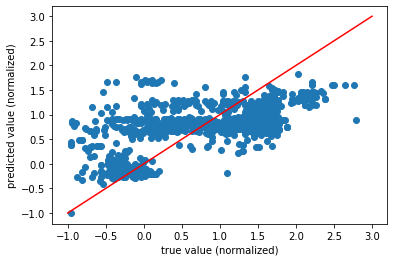

In [6]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [7]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models = cost_models, 
                                               step_formula=superconduct_step_formula,
                                               compression_model = SQuantization(1, dim_notebook+1),
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [15]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0011, -0.1630,  0.2483, -0.1043, -0.0163, -0.0710, -0.3561,  0.1430,
         0.3215, -0.0039, -0.1263, -0.1450,  0.0345,  0.0640, -0.0050, -0.0007,
         0.0925,  0.2040,  0.5010,  0.0906, -0.3708, -0.1595,  0.1989,  0.4584,
        -0.3570, -0.2424,  0.0048,  0.2574,  0.4440, -0.1036, -0.5519,  0.3051,
        -0.2389, -0.0501,  0.0085,  0.2242,  0.1570, -0.2125, -0.1436,  0.0172,
         0.2187, -0.0737, -0.0110,  0.3910,  0.0657, -0.4186,  0.0270, -0.1978,
        -0.5702, -0.1397,  0.6791, -0.2499,  0.1152, -0.1208, -0.0780,  0.0417,
        -0.1036,  0.2466, -0.2163,  0.1346,  0.1115, -0.0582, -0.0045,  0.5609,
        -0.1187, -0.2660,  0.0257,  0.0847, -0.2463, -0.2340,  0.1425,  0.2032,
        -0.0289, -0.0155,  0.0856, -0.0837,  0.2219, -0.3296,  0.1739,  0.0770,
        -0.0398, -0.2332], dtype=torch.float64)


## Without averaging

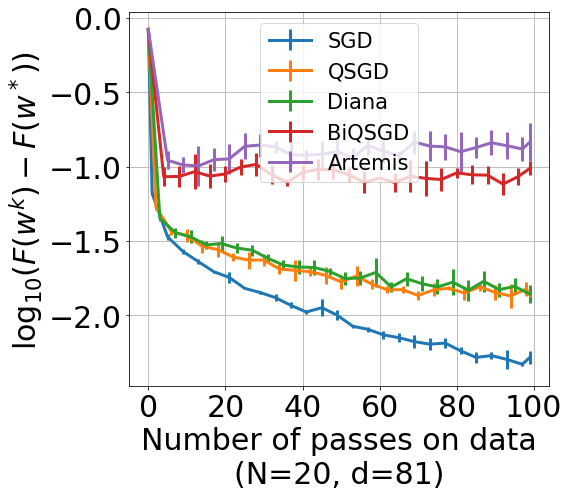

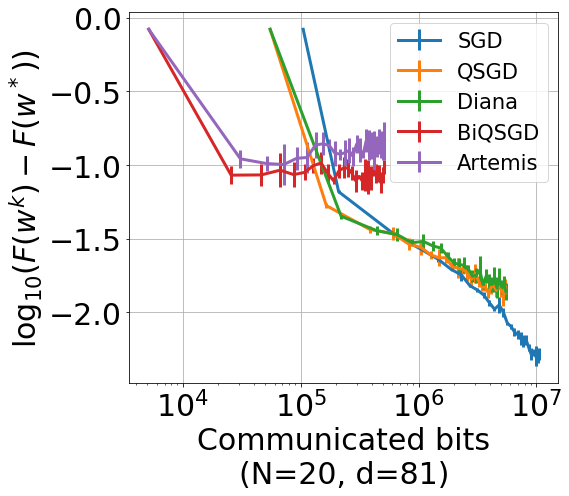

In [16]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

## With averaging

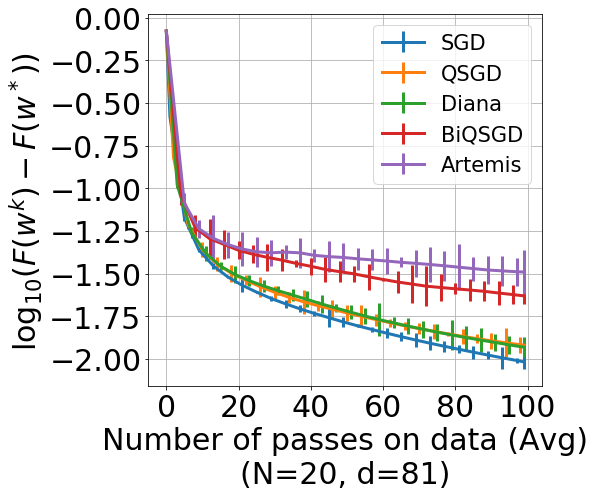

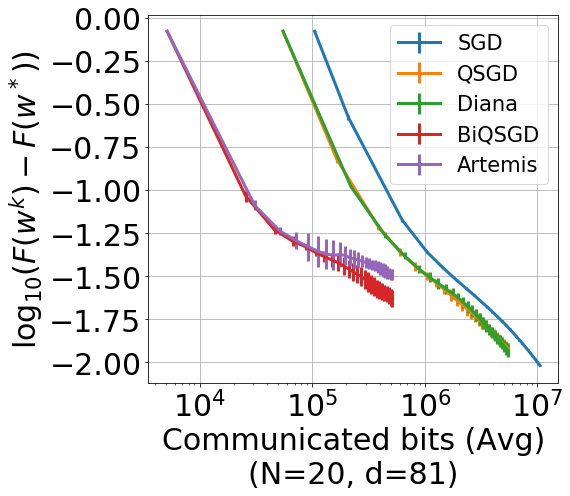

In [17]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Handling non-iid data

In [15]:
def superconduct_step_formula(it, L, omega, N): return 1 / (L)

No missing value. Great !
Scaling data.
There is 81 dimensions.
Head of the dataset:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0           -0.080058          0.046733             -0.451651   
1            0.614744          0.174269             -0.432071   
2           -0.080058          0.046733             -0.450978   
3           -0.080058          0.046733             -0.451314   
4           -0.080058          0.046733             -0.452324   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          -0.158850              -0.611819             0.044358   
1           0.059368              -0.604180             0.777430   
2          -0.158850              -0.611658             0.044358   
3          -0.158850              -0.611739             0.044358   
4          -0.158850              -0.611980             0.044358   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                -0.003707           0.1337

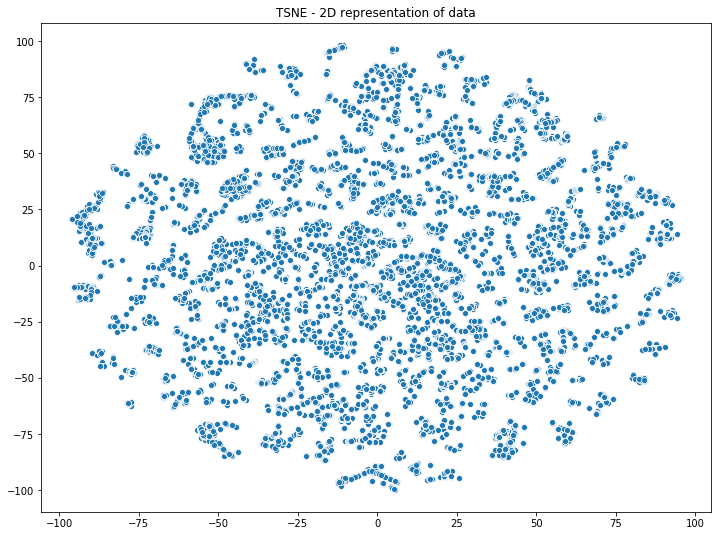

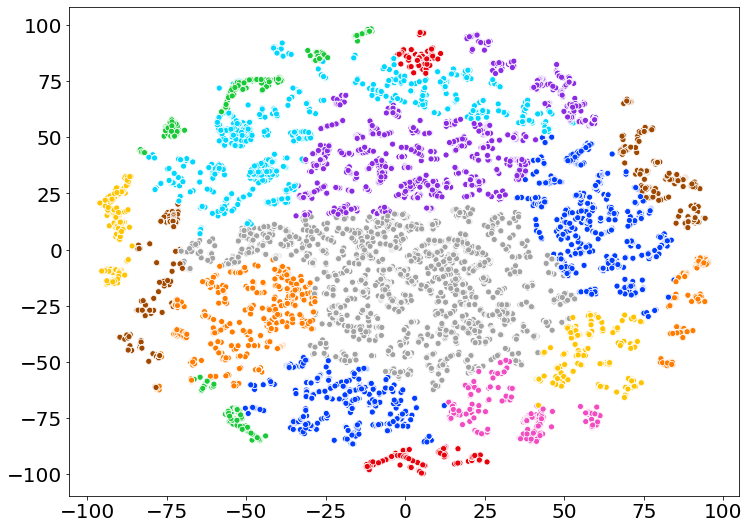

In [2]:
%%time
X, Y, dim_notebook = prepare_superconduct(nb_devices_for_the_run, iid=False)

In [3]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [22]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 2.8520e-01
   20000 | 2.8120e-01
   30000 | 2.7949e-01
   40000 | 2.7856e-01
Gradient Descent: execution time=665.425 seconds
Final loss : 0.27800

CPU times: user 42min 55s, sys: 25.1 s, total: 43min 20s
Wall time: 11min 5s


## Batch size $= 1$ (stochastic)

In [28]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               compression_model = SQuantization(1, dim_notebook + 1),
                                               use_averaging=True, stochastic=True,
                                               step_formula=superconduct_step_formula,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [24]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0172,  0.0093,  0.0928, -0.0286,  0.0682,  0.0426, -0.0874,  0.0799,
         0.2707, -0.0283,  0.1154, -0.1515, -0.0135,  0.0221,  0.0586,  0.0711,
         0.0815,  0.0368,  0.1336,  0.1003, -0.1734, -0.1442,  0.0132,  0.2280,
        -0.0984,  0.0357,  0.0526,  0.1174,  0.2181, -0.2372, -0.0773,  0.2061,
        -0.1362, -0.0527, -0.1064,  0.0350, -0.0524, -0.1613, -0.1514,  0.0851,
         0.1116, -0.1362,  0.1645,  0.0650,  0.0024, -0.2549, -0.0697, -0.1994,
        -0.2838, -0.1291,  0.3213, -0.1156,  0.0654, -0.0129, -0.0423, -0.0423,
        -0.0044,  0.2373, -0.0581,  0.1237, -0.0124, -0.0703,  0.0651,  0.3984,
        -0.0549, -0.2479, -0.0183,  0.1434, -0.1180, -0.1378, -0.0081,  0.2746,
         0.0031, -0.0384,  0.0298, -0.0297,  0.0392, -0.0470,  0.0415,  0.1488,
         0.0078, -0.2265], dtype=torch.float64)


## Without averaging

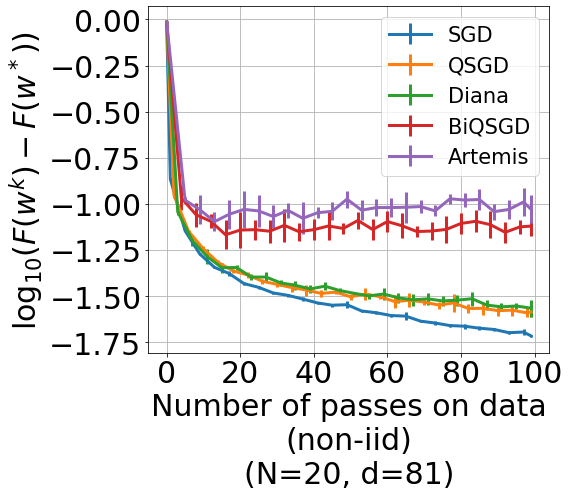

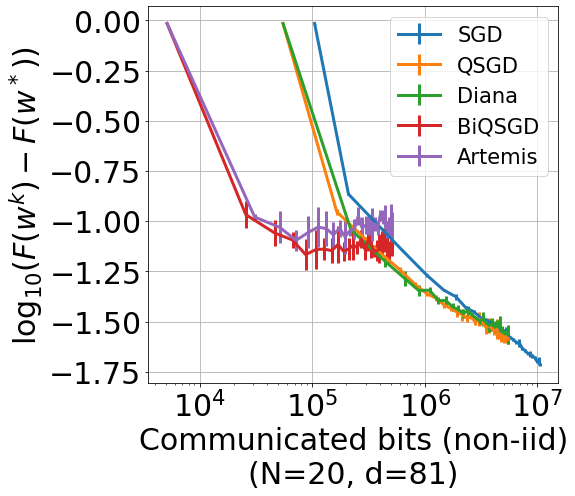

In [25]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## With averaging

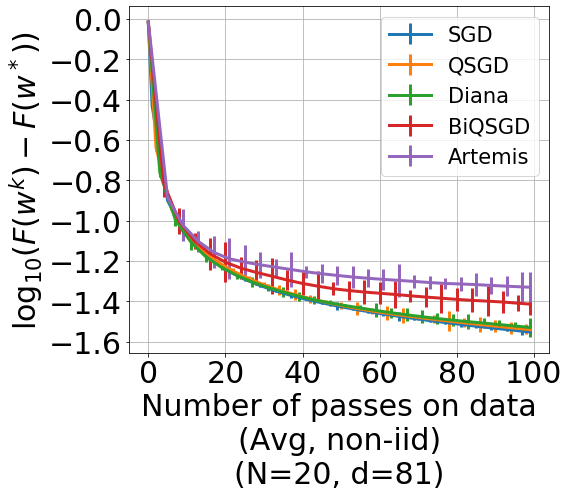

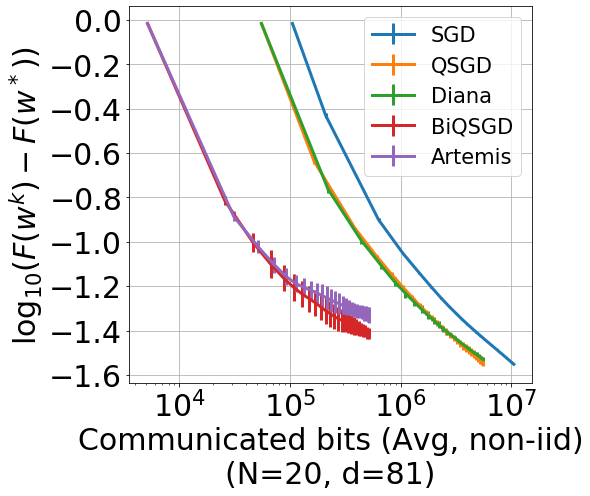

In [26]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, non-iid)") 


## Batch size $= 50$ (stochastic)

In [24]:
%%time
batch_size = 50
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               compression_model = SQuantization(1, dim_notebook + 1),
                                               step_formula=superconduct_step_formula,
                                               use_averaging=False, batch_size=batch_size, 
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-{0}".format(batch_size))

100%|██████████| 5/5 [03:44<00:00, 44.93s/it]

CPU times: user 14min 21s, sys: 10.7 s, total: 14min 32s
Wall time: 3min 44s


In [28]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0186, -0.0061,  0.1138, -0.0445,  0.0765,  0.0258, -0.0956,  0.0596,
         0.2709, -0.0270,  0.1031, -0.1561, -0.0283,  0.0373,  0.0497,  0.0921,
         0.1033,  0.0543,  0.1720,  0.0991, -0.1921, -0.1558,  0.0156,  0.2607,
        -0.1235,  0.0230,  0.0716,  0.1134,  0.2226, -0.2449, -0.1266,  0.2351,
        -0.1366, -0.0517, -0.1126,  0.0487, -0.0464, -0.1640, -0.1689,  0.0805,
         0.1589, -0.1524,  0.1691,  0.0770,  0.0030, -0.2789, -0.0582, -0.2006,
        -0.3455, -0.1372,  0.3976, -0.1399,  0.0743, -0.0170, -0.0459, -0.0395,
        -0.0214,  0.2547, -0.0651,  0.1350, -0.0143, -0.0649,  0.0605,  0.4507,
        -0.0629, -0.2543, -0.0309,  0.1360, -0.1666, -0.1733, -0.0014,  0.2876,
         0.0024, -0.0357,  0.0332, -0.0295,  0.0577, -0.0706,  0.0514,  0.1522,
         0.0066, -0.2335], dtype=torch.float64)


## Without averaging

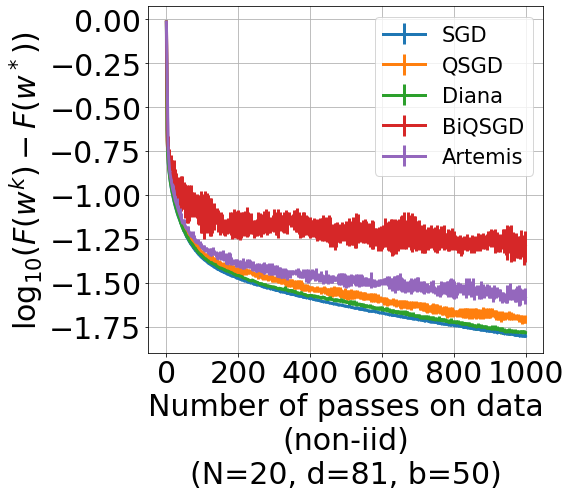

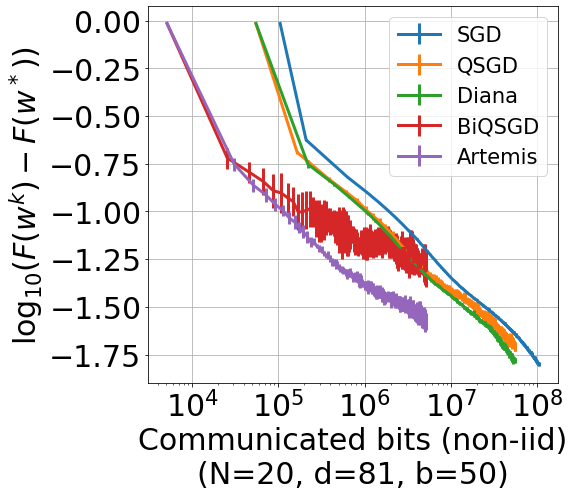

In [29]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,  batch_size=batch_size,
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## With averaging

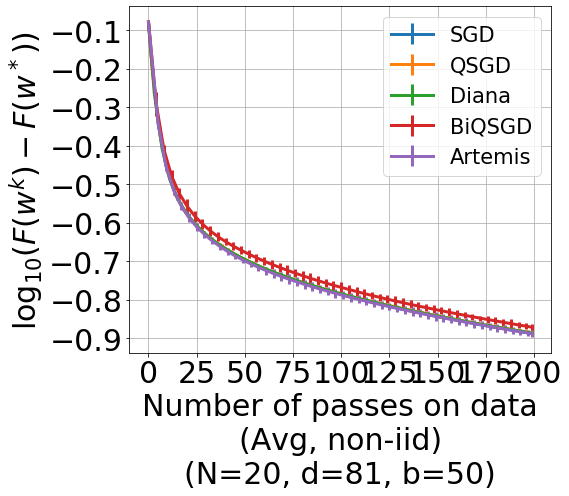

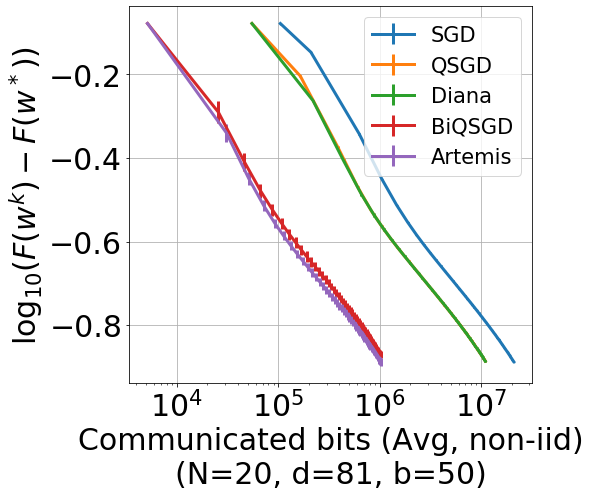

In [11]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Communicated bits (Avg, non-iid)") 